## Origen de Datos

In [75]:
# Librerias a usar 
import pandas as pd 
import numpy as np
import scipy
import pyodbc
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix


from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


In [76]:
# Credenciales 
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_STAGE',
                      UID = 'usconsulta',
                      PWD = 'consulta')

In [77]:

#Extraccion del dataset inical 
## maestro de cursos de la oferta formativa 
query1 = """SELECT A.ID, 
		A.NOMBRE, 
		A.PROPOSITO,
		A.PUBLICO_OBJETIVO,
		B.DESCRIPCION AS TIPO_OFERTA_FORMATIVA,
		C.DESCRIPCION AS AREA_EDUCATIVA,
		D.DESCRIPCION AS NVEL_EDUCATIVO, 
		E.DESCRIPCION AS MODALIDAD_EDUCATIVA
	FROM [st].[SI_acfm.maestro.oferta_formativa] A
	LEFT JOIN [st].[SI_maestro.parametros] B ON A.TIPO_OFERTA_FORMATIVA = B.ID
	LEFT JOIN [st].[SI_maestro.parametros] C ON A.AREA_EDUCATIVA = C.ID
	LEFT JOIN [st].[SI_maestro.parametros] D ON A.NIVEL_EDUCATIVO = D.ID
	LEFT JOIN [st].[SI_maestro.parametros] E ON A.MODALIDAD_EDUCATIVA = E.ID
	WHERE A.ACTIVO = '1' AND B.DESCRIPCION = 'Curso'"""
oferta_formativa_df = pd.read_sql_query(query1,conn)



## interacciones del usuario con sifods
query2 = """SELECT ID_OFERTA_FORMATIVA,DNI_DOCENTE,PREFERENCIA,VISTAS,CALIFICACIONES,CALIFICACION,COMPARTIR,COMENTARIOS FROM st.[SI_acfm.transaccional.oferta_formativa_accion]"""
acciones_df = pd.read_sql_query(query2,conn)

## Participantes en los cursos de la oferta formativa
query3 = """SELECT ID_OFERTA_FORMATIVA, A.ID_PARTICIPANTE,CUMPLIMIENTO_ACTIVIDAD
			FROM [st].[SI_acfm.transaccional.oferta_formativa_curso_participante] A
			INNER JOIN (
						SELECT DISTINCT(ID_PARTICIPANTE),MAX(ID) AS LASTREG
						FROM [st].[SI_acfm.transaccional.oferta_formativa_curso_participante]
						GROUP BY ID_PARTICIPANTE) AS B ON A.ID=B.LASTREG
			WHERE CUMPLIMIENTO_ACTIVIDAD = 'COMPLETARON'"""
curso_participante_df = pd.read_sql_query(query3,conn)


## maestro de docentes inscritos en sifods
query4 = """SELECT ID,DNI,APELLIDO_PATERNO,APELLIDO_MATERNO,APELLIDO_CASADA,APELLIDO_MATERNO_CASADA,NOMBRES,PAIS_DOMICILIO,DEPARTAMENTO_DOMICILIO,PROVINCIA_DOMICILIO
			FROM [st].[SI_maestro.persona]"""
maestro_docentes_df = pd.read_sql_query(query4,conn)

#Cerrar la conexion
conn.close()

**Data Frame extraidos**

In [79]:
oferta_formativa_df.head(10)

,ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,TIPO_OFERTA_FORMATIVA,AREA_EDUCATIVA,NVEL_EDUCATIVO,MODALIDAD_EDUCATIVA
0,122,APRENDIZAJE A NIVEL REAL COMUNICACIÓN,Fortalecer las competencias profesionales de l...,Docente de Educación Básica,Curso,Comunicación,None,EBR
1,116,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO CO...,Fortalecer las competencias de las y los docen...,Docente de Educación Básica,Curso,Comunicación,None,EBR
2,115,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO MA...,Fortalecer las competencias de las y los docen...,Docente de Educación Básica,Curso,Matemática,None,EBR
3,117,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO CI...,Fortalecer las competencias de las y los docen...,Docente de Educación Básica,Curso,Ciencia y Tecnología,None,EBR
4,123,APRENDIZAJE A NIVEL REAL CIENCIA Y TECNOLOGÍA,Fortalecer las competencias profesionales de l...,Docente de Educación Básica,Curso,Ciencia y Tecnología,None,EBR
5,118,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO CC.SS,Fortalecer las competencias de las y los docen...,Docente de Educación Básica,Curso,Ciencias Sociales,None,EBR
6,124,APRENDIZAJE A NIVEL REAL DPCC,Fortalecer las competencias profesionales de l...,Docente de Educación Básica,Curso,"Desarrollo personal, ciudadanía y cívica",None,EBR
7,114,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO PR...,Fortalecer las competencias de las y los docen...,Docente de Educación Básica,Curso,Todas,None,EBR
8,119,APRENDIZAJE A NIVEL REAL INICIAL,Fortalecer las competencias profesionales de l...,Docente de Educación Básica,Curso,Todas,None,EBR
9,120,APRENDIZAJE A NIVEL REAL PRIMARIA,Fortalecer las competencias profesionales de l...,Docente de Educación Básica,Curso,Todas,None,EBR


In [80]:
acciones_df.head(5)

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,PREFERENCIA,VISTAS,CALIFICACIONES,CALIFICACION,COMPARTIR,COMENTARIOS
0,78,06680611,False,5,0,0,0,0
1,34,02286006,False,1,0,0,0,0
2,79,99999999,False,6,0,0,0,0
3,80,99999999,False,3,0,0,0,0
4,81,99999999,False,12,0,0,0,0


In [81]:
curso_participante_df.head(5)

,ID_OFERTA_FORMATIVA,ID_PARTICIPANTE,CUMPLIMIENTO_ACTIVIDAD
0,231,2321664,COMPLETARON
1,231,2314359,COMPLETARON
2,231,2309164,COMPLETARON
3,231,2311152,COMPLETARON
4,231,2323937,COMPLETARON


In [82]:
maestro_docentes_df.head(5)

,ID,DNI,APELLIDO_PATERNO,APELLIDO_MATERNO,APELLIDO_CASADA,APELLIDO_MATERNO_CASADA,NOMBRES,PAIS_DOMICILIO,DEPARTAMENTO_DOMICILIO,PROVINCIA_DOMICILIO
0,49505,70151960,RAMOS,OLARTE,,OLARTE,ROXANA,PERU,APURIMAC,CHINCHEROS
1,49506,43935866,AZAÑERO,BELLIDO,,BELLIDO,JORGE ANTONIO,PERU,TUMBES,TUMBES
2,49507,09419857,CORDOVA,VILLAFUERTE,,VILLAFUERTE,CARLOS,PERU,LIMA,LIMA
3,49508,30962395,RUELAS,FLORES,,FLORES,NALDY LUCY,PERU,AREQUIPA,AREQUIPA
4,49509,42813165,FUMAGALLI,LINDO,,LINDO,MARIA DEL PILAR,PERU,,CALLAO


## Manipulación de datos

**Maestro oferta formativa**

In [83]:
#Conversion a mayusculas el nombre de la oferta formativa
oferta_formativa_df = oferta_formativa_df.apply(lambda x: x.astype(str).str.upper())

In [86]:
# Descripciones de cursos similares 
cursos_similares = oferta_formativa_df.groupby('NOMBRE')['NOMBRE'].count().sort_values(ascending=False).to_frame('CONTEO').reset_index()
print('# Cursos de la oferta formativa con más de dos registros: %d' %len(cursos_similares[cursos_similares['CONTEO']>1]))

# Cursos de la oferta formativa con más de dos registros: 4


In [87]:
oferta_formativa_df

,ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,TIPO_OFERTA_FORMATIVA,AREA_EDUCATIVA,NVEL_EDUCATIVO,MODALIDAD_EDUCATIVA
0,122,APRENDIZAJE A NIVEL REAL COMUNICACIÓN,FORTALECER LAS COMPETENCIAS PROFESIONALES DE L...,DOCENTE DE EDUCACIÓN BÁSICA,CURSO,COMUNICACIÓN,NONE,EBR
1,116,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO CO...,FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...,DOCENTE DE EDUCACIÓN BÁSICA,CURSO,COMUNICACIÓN,NONE,EBR
2,115,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO MA...,FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...,DOCENTE DE EDUCACIÓN BÁSICA,CURSO,MATEMÁTICA,NONE,EBR
3,117,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO CI...,FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...,DOCENTE DE EDUCACIÓN BÁSICA,CURSO,CIENCIA Y TECNOLOGÍA,NONE,EBR
4,123,APRENDIZAJE A NIVEL REAL CIENCIA Y TECNOLOGÍA,FORTALECER LAS COMPETENCIAS PROFESIONALES DE L...,DOCENTE DE EDUCACIÓN BÁSICA,CURSO,CIENCIA Y TECNOLOGÍA,NONE,EBR
...,...,...,...,...,...,...,...,...
124,145,TRATAMIENTO CURRICULAR EN LA PROPUESTA PEDAGÓG...,"EL CURSO VIRTUAL AUTOFORMATIVO, TRATAMIENTO CU...","DOCENTES, DIRECTIVOS Y COORDINADORES DE RED DE...",CURSO,TODAS,TODOS LOS NIVELES,EDUCACIÓN BÁSICA
125,161,EDUCACIÓN INCLUSIVA PARA ATENDER LA DIVERSIDAD...,ESTE CURSO VIRTUAL AUTOFORMATIVO PONE DE RELIE...,DOCENTES DE LA EDUCACIÓN BÁSICA REGULAR,CURSO,TODAS,TODOS LOS NIVELES,EDUCACIÓN BÁSICA
126,163,ÉTICA E INTEGRIDAD EN EL ROL DOCENTE,EL PROPÓSITO DE ESTE CURSO ES QUE LAS Y LOS DO...,DOCENTES DE EDUCACIÓN BÁSICA,CURSO,TODAS,TODOS LOS NIVELES,EDUCACIÓN BÁSICA
127,232,USO PEDAGÓGICO DE MATERIALES EDUCATIVOS: FICHA...,ESTE CURSO VIRTUAL TIENE COMO PROPÓSITO FORTAL...,DOCENTES DE EDUCACIÓN BÁSICA REGULAR DEL NIVEL...,CURSO,TODAS,TODOS LOS NIVELES,EDUCACIÓN BÁSICA


**Transaccional oferta formativa accion**

In [88]:
acciones_df.head(3)

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,PREFERENCIA,VISTAS,CALIFICACIONES,CALIFICACION,COMPARTIR,COMENTARIOS
0,78,06680611,False,5,0,0,0,0
1,34,02286006,False,1,0,0,0,0
2,79,99999999,False,6,0,0,0,0


In [89]:
#Evidencia de valores duplicados
dup_acciones_df = acciones_df.groupby(['ID_OFERTA_FORMATIVA','DNI_DOCENTE'])['DNI_DOCENTE'].count().sort_values(ascending=False).to_frame('CONTEO').reset_index()
dup_acciones_df[dup_acciones_df['CONTEO']>1]

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,CONTEO
0,232,28288231,2
1,243,41819549,2
2,244,07411411,2
3,85,40983586,2
4,249,43412907,2
...,...,...,...
1250,208,46833253,2
1251,138,70768163,2
1252,236,01480167,2
1253,239,41837101,2


In [90]:
#Reduccion de ocurrencias de ID_OFERTA_FORMATIVA, DNI_DOCENTE
acciones_df = acciones_df.drop_duplicates(['ID_OFERTA_FORMATIVA','DNI_DOCENTE'],keep='last')
acciones_df.shape

(248340, 8)

In [91]:
#Cruce de datos con los oferta formativa tipo cursos
# acciones_df['ID_OFERTA_FORMATIVA'] = acciones_df['ID_OFERTA_FORMATIVA'].astype('str')
# acciones_df_validos = oferta_formativa_df.merge(acciones_df , how='left',left_on='ID',right_on='ID_OFERTA_FORMATIVA')
# print('El dataframe acciones tiene %d registros' % acciones_df_validos.shape[0])

El dataframe acciones tiene 142463 registros


**Transaccional oferta formatva curso participante**

Para esta tabla se vio por conveniente realizar un script de sql para poder optimizar la transacción

In [22]:
#Verificar la tabla
curso_participante_df.head(3)

,ID_OFERTA_FORMATIVA,ID_PARTICIPANTE,CUMPLIMIENTO_ACTIVIDAD
0,231,2321664,COMPLETARON
1,231,2314359,COMPLETARON
2,231,2309164,COMPLETARON


**Maestro de docentes**

In [39]:
#Verificar la tabla 
maestro_docentes_df.head(3)

,ID,DNI,APELLIDO_PATERNO,APELLIDO_MATERNO,APELLIDO_CASADA,APELLIDO_MATERNO_CASADA,NOMBRES,PAIS_DOMICILIO,DEPARTAMENTO_DOMICILIO,PROVINCIA_DOMICILIO
0,49505,70151960,RAMOS,OLARTE,,OLARTE,ROXANA,PERU,APURIMAC,CHINCHEROS
1,49506,43935866,AZAÑERO,BELLIDO,,BELLIDO,JORGE ANTONIO,PERU,TUMBES,TUMBES
2,49507,09419857,CORDOVA,VILLAFUERTE,,VILLAFUERTE,CARLOS,PERU,LIMA,LIMA


In [40]:
##Comprobar valores null
maestro_docentes_df.isnull().sum()

ID                            0
DNI                           0
APELLIDO_PATERNO              0
APELLIDO_MATERNO              6
APELLIDO_CASADA            7292
APELLIDO_MATERNO_CASADA    1508
NOMBRES                       0
PAIS_DOMICILIO                0
DEPARTAMENTO_DOMICILIO       22
PROVINCIA_DOMICILIO           1
dtype: int64

- La columna de apellido casada y apellido materno casa no tienen relevancia los valores vacios ya que existen pocas personan que poseen esas caracteristicas
- Existen valores vacios cuando la provincia domicilio es CALLAO

In [41]:
maestro_docentes_df[maestro_docentes_df['DEPARTAMENTO_DOMICILIO'].isnull()].head(3)

,ID,DNI,APELLIDO_PATERNO,APELLIDO_MATERNO,APELLIDO_CASADA,APELLIDO_MATERNO_CASADA,NOMBRES,PAIS_DOMICILIO,DEPARTAMENTO_DOMICILIO,PROVINCIA_DOMICILIO
50597,5425,25775876,MANAVI,HERRERA,None,HERRERA,SONIA CECILIA,PERU,None,CALLAO
53146,7974,18160660,GAVELAN,ESPINOZA,None,ESPINOZA,CARLOS SEGUNDO,PERU,None,CALLAO
53681,8509,40657848,LOPEZ,SANCHEZ,None,SANCHEZ,GISELA SOFIA,PERU,None,CALLAO


In [42]:
## Comprobar duplicados por DNI
dup_maestro_docentes_df = maestro_docentes_df.groupby('DNI')['DNI'].count().sort_values(ascending=False).to_frame('CONTEO').reset_index()
dup_maestro_docentes_df[dup_maestro_docentes_df['CONTEO']>1]


,DNI,CONTEO


In [96]:
#Se elimina los registros duplicados considerando guardar el primer registro
maestro_docentes_df = maestro_docentes_df.drop_duplicates(['DNI'],keep='first')
maestro_docentes_df.head(3) #df maestro docentes sin duplicados 

,ID,DNI,APELLIDO_PATERNO,APELLIDO_MATERNO,APELLIDO_CASADA,APELLIDO_MATERNO_CASADA,NOMBRES,PAIS_DOMICILIO,DEPARTAMENTO_DOMICILIO,PROVINCIA_DOMICILIO
0,49505,70151960,RAMOS,OLARTE,,OLARTE,ROXANA,PERU,APURIMAC,CHINCHEROS
1,49506,43935866,AZAÑERO,BELLIDO,,BELLIDO,JORGE ANTONIO,PERU,TUMBES,TUMBES
2,49507,09419857,CORDOVA,VILLAFUERTE,,VILLAFUERTE,CARLOS,PERU,LIMA,LIMA


# EDA

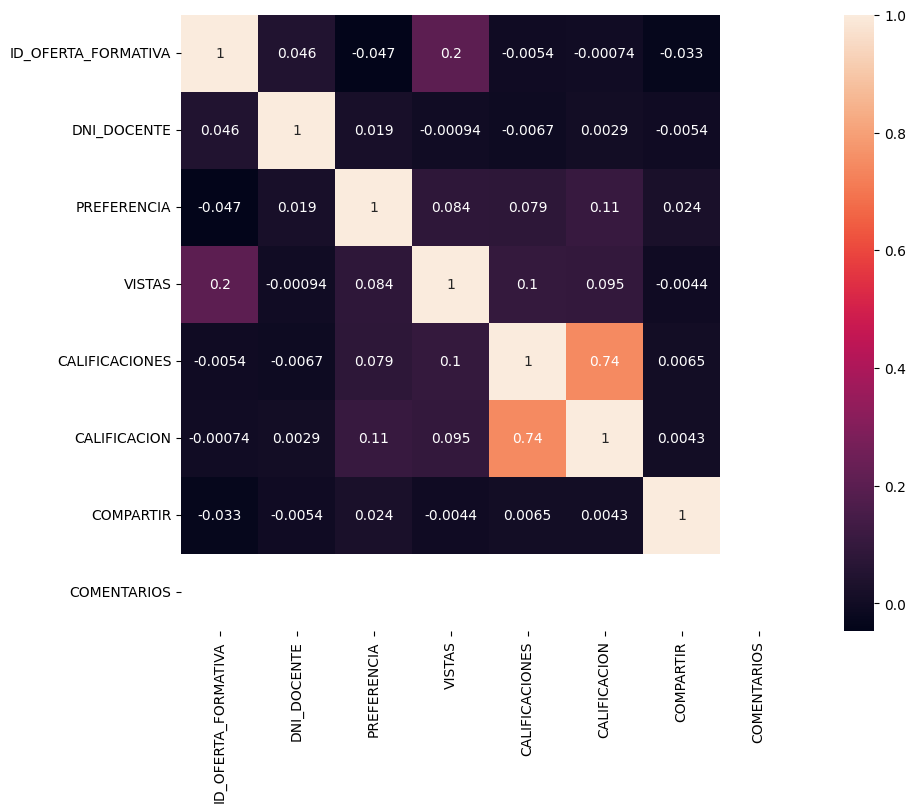

In [97]:
#Correlacion de Pearson 
plt.subplots(figsize=(12, 8))
sns.heatmap(acciones_df.corr(), annot=True, square=True)
plt.show()


<Axes: ylabel='Density'>

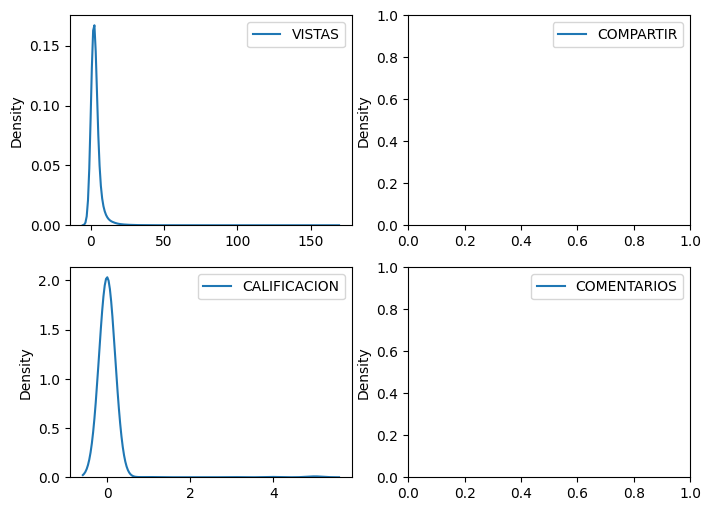

In [45]:
#Grafico de densidad de la variables de interracion 
f, axes = plt.subplots(2, 2, figsize=(8, 6))
sns.kdeplot(acciones_df_validos[["VISTAS"]], bw=0.5, ax=axes[0,0])
sns.kdeplot(acciones_df_validos[["CALIFICACION"]], bw=0.5, ax=axes[1,0])
sns.kdeplot(acciones_df_validos[["COMPARTIR"]], bw=0.5, ax=axes[0,1])
sns.kdeplot(acciones_df_validos[["COMENTARIOS"]], bw=0.5, ax=axes[1,1])

In [46]:
#Df filtrado los cursos validos
df_eda_1 = acciones_df_validos.merge(maestro_docentes_df, how='left',left_on='DNI_DOCENTE',right_on="DNI")

In [47]:
rating_region = df_eda_1[['DEPARTAMENTO_DOMICILIO','VISTAS']].groupby('DEPARTAMENTO_DOMICILIO').sum().reset_index().sort_values('VISTAS',ascending=False).head(10)
rating_region.head(3)


,DEPARTAMENTO_DOMICILIO,VISTAS
20,LIMA,108453.0
18,LA LIBERTAD,31062.0
17,JUNIN,30227.0


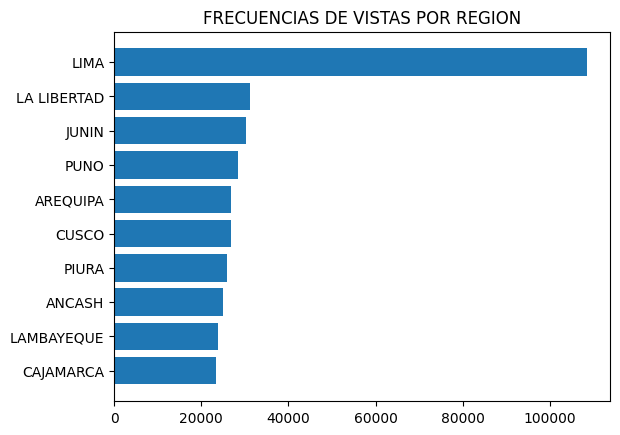

In [48]:
#Departamentos con mayor frecuencias de vistas 
rating_region = rating_region.sort_values('VISTAS', ascending=True)
plt.barh(rating_region['DEPARTAMENTO_DOMICILIO'], rating_region['VISTAS'])
plt.title("FRECUENCIAS DE VISTAS POR REGION")
plt.show()

In [49]:
#Cursos mas populares
rating_oferta_formativa = acciones_df_validos[['ID_OFERTA_FORMATIVA', 'VISTAS']].groupby('ID_OFERTA_FORMATIVA').mean().reset_index().sort_values('VISTAS', ascending=False)
rating_oferta_formativa['ID_OFERTA_FORMATIVA'] = rating_oferta_formativa['ID_OFERTA_FORMATIVA'].astype('str')
#oferta_formativa_df['ID'] = oferta_formativa_df['ID'].astype('str')
rating_oferta_formativa_df = rating_oferta_formativa.merge(cursos_validos, how='left',left_on='ID_OFERTA_FORMATIVA',right_on='ID')
rating_oferta_formativa_df[['NOMBRE','VISTAS']].head(5)

,NOMBRE,VISTAS
0,USO PEDAGÓGICO DE MATERIALES EDUCATIVOS: FICHA...,5.037767
1,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,4.106131
2,ESTRATEGIAS PARA EL DESARROLLO DE UNA CONVIVEN...,3.959979
3,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,3.748220
4,LA LECTURA Y LA ESCRITURA EN LOS PRIMEROS AÑOS...,3.644571


In [50]:
#Frecuencia de cursos mas populares
frecuencia_cursos = acciones_df_validos['ID_OFERTA_FORMATIVA'].value_counts()
# Frecuencia de curso con mas de 100 interacciones
frecuencia_valida_cursos = frecuencia_cursos[frecuencia_cursos > 100].index


In [53]:
#Tomamos como referencia solo los cursos con frecuencia mas de 100
acciones_df_100 = acciones_df_validos[acciones_df_validos['ID_OFERTA_FORMATIVA'].isin(frecuencia_valida_cursos)]
rating_oferta_formativa_100 = acciones_df_100[['ID_OFERTA_FORMATIVA', 'VISTAS']].groupby('ID_OFERTA_FORMATIVA').mean().reset_index().sort_values('VISTAS', ascending=False)
rating_oferta_formativa_100['ID_OFERTA_FORMATIVA'] = rating_oferta_formativa_100['ID_OFERTA_FORMATIVA'] # .astype('int64')
rating_oferta_formativa_df_100 = rating_oferta_formativa_100.merge(oferta_formativa_df, how='left', left_on='ID_OFERTA_FORMATIVA', right_on='ID')
#rating de cursos con promedio de vistas e interracciones mayores a 100
rating_oferta_formativa_df_100[['ID','NOMBRE', 'VISTAS']].head(5)


,ID,NOMBRE,VISTAS
0,232,USO PEDAGÓGICO DE MATERIALES EDUCATIVOS: FICHA...,5.037767
1,205,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,4.106131
2,231,ESTRATEGIAS PARA EL DESARROLLO DE UNA CONVIVEN...,3.959979
3,196,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,3.748220
4,249,LA LECTURA Y LA ESCRITURA EN LOS PRIMEROS AÑOS...,3.644571


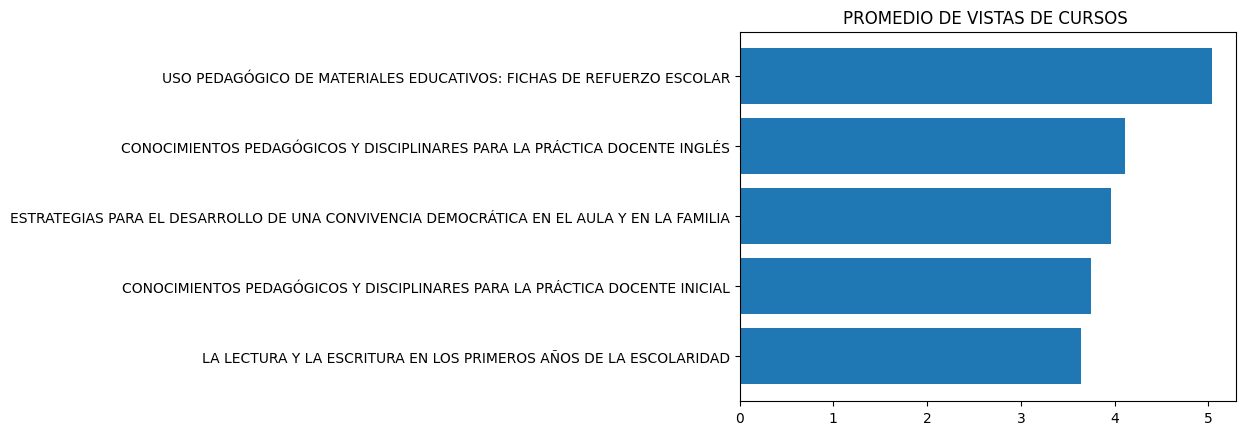

In [54]:
#grafico de promedio de vistas de los cursos e interraciones mayores a 100 top 5
rating_oferta_formativa_top5 = rating_oferta_formativa_df_100.head(5).sort_values('VISTAS',ascending=True)
plt.barh('NOMBRE', 'VISTAS', data=rating_oferta_formativa_top5)
plt.title("PROMEDIO DE VISTAS DE CURSOS ")
plt.show()

# Selección de Variables
Se reviso las columnas de:
- Preferencia : Indica un "me gusta" en el curso
- Vistas : Contador de ingresos a los cursos
- Calificaciones : Numero de calificaciones que se da aun curso 
- Calificación : Puntuacion que se le asigna a un curso (las estrellas de que van de 0 a 5 )
- Compartir : Contador de la opcion compartir ( se puede compartir por facebook,linkedin, whatsapp, pinterest y twiter )
- Comentarios : Comentarios sobre el curso 

Los sistemas de recomendación se enfrentan al problema conocido como "arranque en frio", en el que es dificil proporcionar recomendaciones personalizadas a usuarios que no han consumido nada o muy poco
por ese motivo se excluiran a las personas con 0 vistas y con acciones en un solo curso

In [55]:
#Preferencia 
Porcentaje_preferencia=round((len(acciones_df_validos[acciones_df_validos['PREFERENCIA'] == 1]) / len(acciones_df_validos) )* 100,1)
Porcentaje_vistas = round((len(acciones_df_validos[acciones_df_validos['VISTAS'] > 1]) / len(acciones_df_validos)) * 100,1)
Porcentaje_calificaciones = round((len(acciones_df_validos[acciones_df_validos['CALIFICACIONES'] > 1]) / len(acciones_df_validos)) * 100,1)
Porcentaje_califacion = round((len(acciones_df_validos[acciones_df_validos['CALIFICACION'] >0 ]) / len(acciones_df_validos)) * 100,1)
Porcentaje_compartir = round((len(acciones_df_validos[acciones_df_validos['COMPARTIR'] >0 ]) / len(acciones_df_validos)) * 100,1)
Porcentaje_comentarios = round((len(acciones_df_validos[acciones_df_validos['COMENTARIOS'] >0 ]) / len(acciones_df_validos)) * 100,1)

print('Porcentaje de datos en la variable PREFERENCIA : ' + str(Porcentaje_preferencia) + '%')
print('Porcentaje de datos en la variable VISTAS : ' + str(Porcentaje_vistas) + '%')
print('Porcentaje de datos en la variable CALIFICACIONES : ' + str(Porcentaje_calificaciones) + '%')
print('Porcentaje de datos en la variable CALIFICACION : ' + str(Porcentaje_califacion) + '%')
print('Porcentaje de datos en la variable COMPARTIR : ' + str(Porcentaje_compartir) + '%')
print('Porcentaje de datos en la variable COMENTARIOS : ' + str(Porcentaje_comentarios) + '%')

Porcentaje de datos en la variable PREFERENCIA : 3.1%
Porcentaje de datos en la variable VISTAS : 83.5%
Porcentaje de datos en la variable CALIFICACIONES : 0.3%
Porcentaje de datos en la variable CALIFICACION : 0.9%
Porcentaje de datos en la variable COMPARTIR : 0.0%
Porcentaje de datos en la variable COMENTARIOS : 0.0%


In [99]:
acciones_df = acciones_df[acciones_df['VISTAS']>0]

In [101]:
usuario_interaccion_count = acciones_df.groupby(['DNI_DOCENTE', 'ID_OFERTA_FORMATIVA']).size().groupby('DNI_DOCENTE').size()
print('# usuarios: %d' % len(usuario_interaccion_count))
usuario_considerado = usuario_interaccion_count[usuario_interaccion_count > 1].reset_index()[['DNI_DOCENTE']]
print('# usuarios con mas de 1 accion:  %d' % len(usuario_considerado)) 

# usuarios: 93405
# usuarios con mas de 1 accion:  49789


In [100]:
print('# de  acciones %d' % len(acciones_df))
acciones_seleccionadas = acciones_df.merge(usuario_considerado,
                                        how = 'right',
                                        left_on = 'DNI_DOCENTE',
                                        right_on = 'DNI_DOCENTE')
print('# de acciones de usuarios seleccionados : %d' %len(acciones_seleccionadas))

# de  acciones 247052
# de acciones de usuarios seleccionados : 152840


In [103]:
#Seleccionamos  las columnas de interes del dataframe acciones_seleccionadas
acciones_full_df=acciones_seleccionadas[['ID_OFERTA_FORMATIVA','DNI_DOCENTE','VISTAS']]
acciones_full_df.head()

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,VISTAS
0,232,00002741,26.0
1,196,00002741,2.0
2,242,00002741,9.0
3,198,00002741,1.0
4,232,00006226,3.0


In [63]:
scaler=MinMaxScaler()
acciones_full_df['CALIFICACION_TRANSFORMADO']=scaler.fit_transform(acciones_full_df[['VISTAS']])

In [64]:
acciones_full_df


,ID_OFERTA_FORMATIVA,DNI_DOCENTE,VISTAS,CALIFICACION_TRANSFORMADO
0,196,00002741,2.0,0.012195
1,198,00002741,1.0,0.006098
2,232,00002741,26.0,0.158537
3,231,00006226,3.0,0.018293
4,232,00006226,3.0,0.018293
...,...,...,...,...
104764,131,99999998,2.0,0.012195
104765,160,99999998,2.0,0.012195
104766,158,99999998,1.0,0.006098
104767,121,99999998,3.0,0.018293


# Modelado

In [109]:
print('# de interacciones: %d' % len(acciones_df))
registros_duplicados = acciones_full_df.groupby(['DNI_DOCENTE', 'ID_OFERTA_FORMATIVA'])['DNI_DOCENTE'].count().to_frame('CONT').reset_index().sort_values('CONT', ascending=False)
registros_duplicados = registros_duplicados[registros_duplicados['CONT']==1]
acciones_full_valido_df = acciones_full_df.merge(registros_duplicados, how='right' , left_on=['DNI_DOCENTE','ID_OFERTA_FORMATIVA'],right_on=['DNI_DOCENTE','ID_OFERTA_FORMATIVA'])
print('# de interacciones validos %d' %len(acciones_full_valido_df))

# de interacciones: 247052
# de interacciones validos 152835


In [72]:
acciones_full_valido_df.head(3)

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,VISTAS,CALIFICACION_TRANSFORMADO,CONT
0,196,00002741,2.0,0.012195,1
1,231,42250444,3.0,0.018293,1
2,120,42250576,1.0,0.006098,1


### Modelo de Popularidad

In [74]:
#Calcula los articulos mas populares
curos_populares = acciones_full_valido_df.groupby(['ID_OFERTA_FORMATIVA'])['VISTAS'].sum().sort_values(ascending=False).reset_index()
curos_populares.head(5)

,ID_OFERTA_FORMATIVA,VISTAS
0,232,54102.0
1,231,32148.0
2,197,30711.0
3,196,27172.0
4,199,14891.0


In [299]:
#Creación de una tabla dinámica dispersa con usuarios en filas y elementos en columnas
usuario_item_pivot_matrix_df = acciones_full_valido_df.pivot(index='DNI_DOCENTE',
                                                                columns='ID_OFERTA_FORMATIVA',
                                                             values='CALIFICACION_TRANSFORMADO')

usuario_item_pivot_matrix_df.head(10)


ID_OFERTA_FORMATIVA,1,10,105,106,107,108,109,11,110,112,...,62,63,64,67,68,7,72,73,8,9
DNI_DOCENTE,,,,,,,,,,,,,,,,,,,,,
00002741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00006226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00007342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000073850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00007462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00008538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00010885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00011708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00015535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [300]:
# Calculando matrix sparsity
sparsity_count = usuario_item_pivot_matrix_df.isnull().values.sum()
# Contar todas las celdas
full_cont = usuario_item_pivot_matrix_df.size
# Numero de escazes del dataset
sparsity = round(sparsity_count / full_cont, 3)
print('El dataset tiene una escasez de : ' + str(sparsity*100) + '%')


El dataset tiene una escasez de : 97.5%


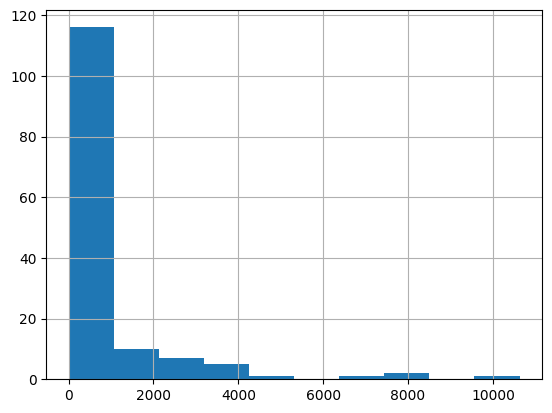

In [301]:
# Contar las celdas ocupadas por columna
count_celdas_ocupadas = usuario_item_pivot_matrix_df.notnull().sum()
# Ordenar el resultado de mayot a menor
sorted_count_celdas_ocupadas = count_celdas_ocupadas.sort_values()
# Plot Histograma
sorted_count_celdas_ocupadas.hist()
plt.show()


## Descomposión de valores singulares (SVD)

In [302]:
# Obtener la valoración media de cada usuario
avg_rating = usuario_item_pivot_matrix_df.mean(axis=1)
# Centrar las valoraciones de los usuarios entorno a 0
df_pivot_centered = usuario_item_pivot_matrix_df.sub(avg_rating, axis=0)
# Rellenar los datos que faltan con 0
df_pivot_centered.fillna(0, inplace=True)
# Comprobar la matriz centrada
print(df_pivot_centered.mean(axis=1))


DNI_DOCENTE
00002741     1.940949e-19
00006226     0.000000e+00
00007342     0.000000e+00
000073850    2.426187e-20
00007462     0.000000e+00
                 ...     
80684683     4.852373e-20
80685802    -1.213093e-20
80685932     4.852373e-20
80688103    -1.213093e-20
99999998    -3.639280e-20
Length: 31577, dtype: float64


In [303]:
# Descomponer la Matrix
U, sigma, Vt = svds(df_pivot_centered.to_numpy())
# Converitir el sigma en la diagonal de la matriz
sigma = np.diag(sigma)


In [304]:
# Producto de puntos
U_sigma = np.dot(U, sigma)
# Producto de puntos del resultado
U_sigma_Vt = np.dot(U_sigma, Vt)
# Las medias de las filas contenidas
Calificaciones_descentradas = U_sigma_Vt + avg_rating.values.reshape(-1, 1)

calc_pred_df = pd.DataFrame(Calificaciones_descentradas,
                            index=usuario_item_pivot_matrix_df.index,
                            columns=usuario_item_pivot_matrix_df.columns)

print(calc_pred_df)


ID_OFERTA_FORMATIVA         1        10       105       106       107  \
DNI_DOCENTE                                                             
00002741             0.058793  0.058941  0.058778  0.058761  0.058234   
00006226             0.018293  0.018293  0.018293  0.018293  0.018293   
00007342             0.021350  0.021341  0.021351  0.021350  0.021359   
000073850            0.011178  0.011179  0.011177  0.011178  0.011172   
00007462             0.042684  0.042683  0.042684  0.042682  0.042685   
...                       ...       ...       ...       ...       ...   
80684683             0.018322  0.018292  0.018313  0.018317  0.018314   
80685802             0.008130  0.008130  0.008130  0.008130  0.008130   
80685932             0.023088  0.023037  0.023119  0.023078  0.023370   
80688103             0.008141  0.008130  0.008136  0.008132  0.008151   
99999998             0.010162  0.010162  0.010160  0.010161  0.010141   

ID_OFERTA_FORMATIVA       108       109        11 

In [305]:
# Ordenar la valoración del usuario 5 de mayor a menor
user_100_ratings = calc_pred_df.iloc[0, :].sort_values(ascending=False)
print(user_100_ratings.head(10))


ID_OFERTA_FORMATIVA
232    0.159518
199    0.076059
160    0.066587
208    0.064283
197    0.061741
250    0.061057
231    0.060702
36     0.060377
154    0.059589
35     0.059490
Name: 00002741, dtype: float64


# Evaluación

In [306]:
# Comparar los metodos de recomendación
# Extraer los valores verdaderos para comparar las predicciones
actual_valor = usuario_item_pivot_matrix_df.iloc[:20, :100].values
predict_values = calc_pred_df.iloc[:20,:100].values 
mask = ~np.isnan(actual_valor)
print(mean_squared_error(actual_valor[mask], predict_values[mask],squared=False))

0.014348985020037812


# Predicción

In [307]:
calc_pred_df = pd.DataFrame(calc_pred_df)
calc_pred_df = calc_pred_df.reset_index()
calc_pred_df.head()


ID_OFERTA_FORMATIVA,DNI_DOCENTE,1,10,105,106,107,108,109,11,110,...,62,63,64,67,68,7,72,73,8,9
0,00002741,0.058793,0.058941,0.058778,0.058761,0.058234,0.058029,0.058209,0.058945,0.058093,...,0.058078,0.058480,0.059168,0.058845,0.058430,0.058583,0.058797,0.058111,0.058651,0.058924
1,00006226,0.018293,0.018293,0.018293,0.018293,0.018293,0.018293,0.018293,0.018293,0.018293,...,0.018293,0.018293,0.018293,0.018293,0.018293,0.018293,0.018293,0.018293,0.018293,0.018293
2,00007342,0.021350,0.021341,0.021351,0.021350,0.021359,0.021357,0.021373,0.021341,0.021377,...,0.021367,0.021353,0.021354,0.021346,0.021363,0.021351,0.021344,0.021384,0.021357,0.021342
3,000073850,0.011178,0.011179,0.011177,0.011178,0.011172,0.011169,0.011170,0.011179,0.011168,...,0.011172,0.011172,0.011180,0.011179,0.011171,0.011178,0.011179,0.011174,0.011179,0.011179
4,00007462,0.042684,0.042683,0.042684,0.042682,0.042685,0.042684,0.042683,0.042683,0.042687,...,0.042685,0.042684,0.042680,0.042682,0.042685,0.042684,0.042682,0.042686,0.042684,0.042683


In [308]:
# Obtener dataset de resultados
df_f = calc_pred_df.melt(id_vars='DNI_DOCENTE', var_name='ID_OFERTA_FORMATIVA', value_name='CALIFICACION_TRANSFORMADO')
df_f['CALIFICACION_TRANSFORMADO'] = np.round(df_f['CALIFICACION_TRANSFORMADO'], 5)
df_f.head(10)

,DNI_DOCENTE,ID_OFERTA_FORMATIVA,CALIFICACION_TRANSFORMADO
0,00002741,1,0.05879
1,00006226,1,0.01829
2,00007342,1,0.02135
3,000073850,1,0.01118
4,00007462,1,0.04268
5,00008538,1,0.01220
6,00010885,1,0.02439
7,00011708,1,0.03049
8,00015535,1,0.01525
9,00015728,1,0.01829


In [309]:
# Prueba con el docente de dni 00015535 
df_f[df_f['DNI_DOCENTE']== '00015535'].sort_values(by='CALIFICACION_TRANSFORMADO', ascending= False).head(5)

,DNI_DOCENTE,ID_OFERTA_FORMATIVA,CALIFICACION_TRANSFORMADO
1705166,00015535,199,0.01564
2020936,00015535,208,0.01551
1926205,00015535,205,0.01548
1957782,00015535,206,0.01547
1894628,00015535,204,0.01545


## Recomendaciones basadas en contenido 

In [252]:
oferta_formativa_df_contenido = oferta_formativa_df[['ID','AREA_EDUCATIVA']]
oferta_formativa_df_contenido.head(5)

,ID,AREA_EDUCATIVA
0,122,COMUNICACIÓN
1,116,COMUNICACIÓN
2,115,MATEMÁTICA
3,117,CIENCIA Y TECNOLOGÍA
4,123,CIENCIA Y TECNOLOGÍA


In [121]:
area_educativa_df = pd.crosstab(oferta_formativa_df_contenido['ID'],oferta_formativa_df_contenido['AREA_EDUCATIVA'])
area_educativa_df.tail(10)

AREA_EDUCATIVA,ARTE Y CULTURA,AULA DE INNOVACIÓN,CIENCIA Y TECNOLOGÍA,CIENCIAS SOCIALES,COMUNICACIÓN,"DESARROLLO PERSONAL, CIUDADANÍA Y CÍVICA",EDUCACIÓN FÍSICA,EDUCACIÓN PARA EL TRABAJO,EDUCACIÓN RELIGIOSA,EVENTOS REGIONALES,INGLÉS,INTEGRADO,MATEMÁTICA,TODAS
ID,,,,,,,,,,,,,,
285,0,0,0,0,0,0,0,0,0,0,0,0,0,1
286,0,0,0,0,0,0,0,0,0,0,0,0,0,1
287,0,0,0,0,0,0,0,0,0,0,0,0,0,1
288,0,0,0,0,0,0,0,0,0,0,0,0,0,1
289,0,0,0,0,0,0,0,0,0,0,0,0,0,1
290,0,0,0,0,0,0,0,0,0,0,0,0,0,1
291,0,0,0,0,0,0,0,0,0,0,0,0,0,1
292,0,0,0,0,0,0,0,0,0,0,0,0,0,1
293,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [149]:
distances_area_df = area_educativa_df.reset_index()

In [128]:
#Ejemplo de calculo de similitud jaccard
from sklearn.metrics import jaccard_score

id_294 = area_educativa_df.loc['294']
id_291 = area_educativa_df.loc['291']

print('el resultados es :  %d ya que tienen como area educativa el seleccionado TODAS ' %jaccard_score(id_294,id_291))


el resultados es :  1 ya que tienen como area educativa el seleccionado TODAS 


In [130]:
from scipy.spatial.distance import pdist, squareform

jaccard_similitud = pdist(area_educativa_df.values, metric='jaccard')
print(jaccard_similitud)

[0. 0. 0. ... 0. 0. 0.]


In [131]:
square_jaccard_distances = squareform(jaccard_similitud)
print(square_jaccard_distances)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


La función pdist calcula la distancia de jaccard que es una medida de qué tan diferentes son las filas entre si, como queremos el complemento de esto, la similitud, restamos los valores de 1

In [134]:
jaccard_similitud_array = 1 - square_jaccard_distances
print(jaccard_similitud_array)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [146]:
area_educativa_df.iloc[:,0]

ID
105    0
106    0
107    0
108    0
109    0
      ..
290    0
291    0
292    0
293    0
294    0
Name: ARTE Y CULTURA, Length: 129, dtype: int64

In [151]:
distance_df = pd.DataFrame(jaccard_similitud_array,index = distances_area_df['ID'],columns = distances_area_df['ID'])
distance_df.head(4)

ID,105,106,107,108,109,110,112,113,114,115,...,285,286,287,288,289,290,291,292,293,294
ID,,,,,,,,,,,,,,,,,,,,,
105,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
106,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
107,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
108,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [251]:
#Recomendaciones basados en contenido del curso con id 234
distance_df.loc['234'].sort_values(ascending=False)

ID
105    1.0
106    1.0
261    1.0
260    1.0
259    1.0
      ... 
201    0.0
200    0.0
199    0.0
198    0.0
124    0.0
Name: 234, Length: 129, dtype: float64

## Similitudes Basadas en Texto
Consta de realizar recomendaciones basadas en el proposito u objetivo de los cursos disponibles

In [152]:
oferta_formativa_df.head(3)

,ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,TIPO_OFERTA_FORMATIVA,AREA_EDUCATIVA,NVEL_EDUCATIVO,MODALIDAD_EDUCATIVA
0,122,APRENDIZAJE A NIVEL REAL COMUNICACIÓN,FORTALECER LAS COMPETENCIAS PROFESIONALES DE L...,DOCENTE DE EDUCACIÓN BÁSICA,CURSO,COMUNICACIÓN,NONE,EBR
1,116,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO CO...,FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...,DOCENTE DE EDUCACIÓN BÁSICA,CURSO,COMUNICACIÓN,NONE,EBR
2,115,EVALUACIÓN DIAGNÓSTICA PARA EL BUEN RETORNO MA...,FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...,DOCENTE DE EDUCACIÓN BÁSICA,CURSO,MATEMÁTICA,NONE,EBR


In [202]:
cursos_summary_df = oferta_formativa_df[['ID','PROPOSITO']]
print(cursos_summary_df)

      ID                                          PROPOSITO
0    122  FORTALECER LAS COMPETENCIAS PROFESIONALES DE L...
1    116  FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...
2    115  FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...
3    117  FORTALECER LAS COMPETENCIAS DE LAS Y LOS DOCEN...
4    123  FORTALECER LAS COMPETENCIAS PROFESIONALES DE L...
..   ...                                                ...
124  145  EL CURSO VIRTUAL AUTOFORMATIVO, TRATAMIENTO CU...
125  161  ESTE CURSO VIRTUAL AUTOFORMATIVO PONE DE RELIE...
126  163  EL PROPÓSITO DE ESTE CURSO ES QUE LAS Y LOS DO...
127  232  ESTE CURSO VIRTUAL TIENE COMO PROPÓSITO FORTAL...
128  234  SU PROPÓSITO ES FORTALECER LAS COMPETENCIAS PR...

[129 rows x 2 columns]


In [203]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [195]:
from nltk.corpus import stopwords

In [196]:
stopwords_list = stopwords.words('spanish')

In [212]:
#mind_df = 5 , limita aquellas palabras clave que han ocurrido al menos cinco cursos
# max_df = 0.7 se excluyen las palabras que aparezcan en más del 70% de las descripciones
#stop_words lista de palabras vacias en Español
tfidfvec = TfidfVectorizer(min_df=5,max_df=0.7,stop_words=stopwords_list)

In [213]:
vectorized_data = tfidfvec.fit_transform(cursos_summary_df['PROPOSITO'])
print(tfidfvec.get_feature_names_out())

['abordarán' 'actividades' 'acuerdo' 'aprendizaje' 'aprendizajes' 'así'
 'atender' 'autoformativo' 'busca' 'básica' 'básicos' 'cada' 'ciclo'
 'cneb' 'competencia' 'competencias' 'comprende' 'comprensión'
 'comunicación' 'conceptos' 'condiciones' 'conocimientos' 'contratados'
 'cuarta' 'cuatro' 'cumplir' 'currículo' 'curso' 'cyt' 'cómo' 'denomina'
 'denominada' 'desarrolla' 'desarrollo' 'diagnóstica' 'dichas'
 'disciplinares' 'diseñar' 'docente' 'dos' 'dpcc' 'educación' 'educativa'
 'educativas' 'enfoque' 'enfoques' 'escolar' 'estrategias' 'estudiantes'
 'evaluación' 'experiencias' 'familias' 'fortalecer' 'función'
 'fundamentales' 'habilidades' 'haciendo' 'incorporando' 'inicial'
 'inicio' 'instituciones' 'manera' 'marco' 'matemática' 'metodología'
 'nacional' 'necesidades' 'nivel' 'niveles' 'nombrados' 'organizado'
 'participantes' 'pedagógica' 'pedagógicos' 'periodo' 'permita' 'presente'
 'primaria' 'primera' 'principales' 'problemas' 'procesos' 'profesionales'
 'propuesta' 'propósit

In [214]:
print(vectorized_data.toarray())

[[0.         0.24965022 0.         ... 0.         0.         0.21490446]
 [0.         0.         0.         ... 0.29894146 0.         0.        ]
 [0.         0.         0.         ... 0.29894146 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.10933372 ... 0.21866743 0.07890007 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [253]:
#Formatear los datos 
tfidf = pd.DataFrame(vectorized_data.toarray(),
                            columns=tfidfvec.get_feature_names_out())
tfidf.index = cursos_summary_df['ID']
tfidf

,abordarán,actividades,acuerdo,aprendizaje,aprendizajes,así,atender,autoformativo,busca,básica,...,segunda,sesiones,sesión,tercera,teórico,unidad,unidades,uso,virtual,área
ID,,,,,,,,,,,,,,,,,,,,,
122,0.0,0.24965,0.000000,0.188854,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.214904
116,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.298941,0.000000,0.000000
115,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.298941,0.000000,0.000000
117,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.298941,0.000000,0.000000
123,0.0,0.24965,0.000000,0.188854,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.214904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.0,0.00000,0.000000,0.160048,0.0,0.0,0.234943,0.160048,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.152679,0.000000
161,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.303474,0.206732,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.197214,0.000000
163,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.293451,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000


In [218]:
#similitud de coseno
from sklearn.metrics.pairwise import cosine_similarity

# Buscar la similitud entre todos los cursos
cosine_similarity_array = cosine_similarity(tfidf)

In [240]:
tfidf

,abordarán,actividades,acuerdo,aprendizaje,aprendizajes,así,atender,autoformativo,busca,básica,...,segunda,sesiones,sesión,tercera,teórico,unidad,unidades,uso,virtual,área
ID,,,,,,,,,,,,,,,,,,,,,
122,0.0,0.24965,0.000000,0.188854,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.214904
116,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.298941,0.000000,0.000000
115,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.298941,0.000000,0.000000
117,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.298941,0.000000,0.000000
123,0.0,0.24965,0.000000,0.188854,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.214904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.0,0.00000,0.000000,0.160048,0.0,0.0,0.234943,0.160048,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.152679,0.000000
161,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.303474,0.206732,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.197214,0.000000
163,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.293451,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000


In [244]:
#Prueba de la funcion cosine_similarity para las dos Id de cursos
cosine_similarity(tfidf.loc['122'].values.reshape(1,-1),
                    tfidf.loc['234'].values.reshape(1,-1))

array([[0.22626985]])

In [254]:
cosine_resul_df = pd.DataFrame(cosine_similarity_array,
                                index=cursos_summary_df['ID'],
		                         columns = cursos_summary_df['ID'])
cosine_resul_df

ID,122,116,115,117,123,118,124,114,119,120,...,289,290,291,292,293,145,161,163,232,234
ID,,,,,,,,,,,,,,,,,,,,,
122,1.000000,0.132870,0.132870,0.132870,1.000000,0.132870,1.000000,0.132870,1.000000,1.000000,...,0.071665,0.071665,0.071665,0.071665,0.136237,0.313406,0.221068,0.215431,0.126253,0.226270
116,0.132870,1.000000,1.000000,1.000000,0.132870,1.000000,0.132870,1.000000,0.132870,0.132870,...,0.000000,0.000000,0.000000,0.000000,0.040888,0.197988,0.160540,0.178968,0.204529,0.136451
115,0.132870,1.000000,1.000000,1.000000,0.132870,1.000000,0.132870,1.000000,0.132870,0.132870,...,0.000000,0.000000,0.000000,0.000000,0.040888,0.197988,0.160540,0.178968,0.204529,0.136451
117,0.132870,1.000000,1.000000,1.000000,0.132870,1.000000,0.132870,1.000000,0.132870,0.132870,...,0.000000,0.000000,0.000000,0.000000,0.040888,0.197988,0.160540,0.178968,0.204529,0.136451
123,1.000000,0.132870,0.132870,0.132870,1.000000,0.132870,1.000000,0.132870,1.000000,1.000000,...,0.071665,0.071665,0.071665,0.071665,0.136237,0.313406,0.221068,0.215431,0.126253,0.226270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.313406,0.197988,0.197988,0.197988,0.313406,0.197988,0.313406,0.197988,0.313406,0.313406,...,0.000000,0.000000,0.000000,0.000000,0.361748,1.000000,0.443356,0.289801,0.285907,0.450104
161,0.221068,0.160540,0.160540,0.160540,0.221068,0.160540,0.221068,0.160540,0.221068,0.221068,...,0.000000,0.000000,0.000000,0.000000,0.263008,0.443356,1.000000,0.164446,0.325888,0.815387
163,0.215431,0.178968,0.178968,0.178968,0.215431,0.178968,0.215431,0.178968,0.215431,0.215431,...,0.000000,0.000000,0.000000,0.000000,0.317823,0.289801,0.164446,1.000000,0.122368,0.196976


In [255]:
#Prueba de cursos recomendados para el ID = 234
cosine_resul_df.loc['234'].sort_values(ascending=False)

ID
234    1.000000
161    0.815387
145    0.450104
144    0.400062
251    0.362669
         ...   
258    0.000000
259    0.000000
260    0.000000
261    0.000000
220    0.000000
Name: 234, Length: 129, dtype: float64